# So we need to make the image from perspective to bird's eye.


How do we do this? 


Step 1. Find the horizon 

Step 2. Crop the image for everything below the horizon(remembering what the center of the original image)

Step 3. Given height, angle of camera, and center of image we have a reference distance on the screen.(Everything has to be stable at this point! We need(!!) to know the angle of the camera)

Step 4. move pixels to new location using transformation I provide. 

Step 5. Interpolate for missing pixels at outer end. 

Step 6. Rotate as desired

Step 7. Stich together images to make a map of the track

 ## Step 1. 

In [2]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
Image = cv2.imread('example.png')

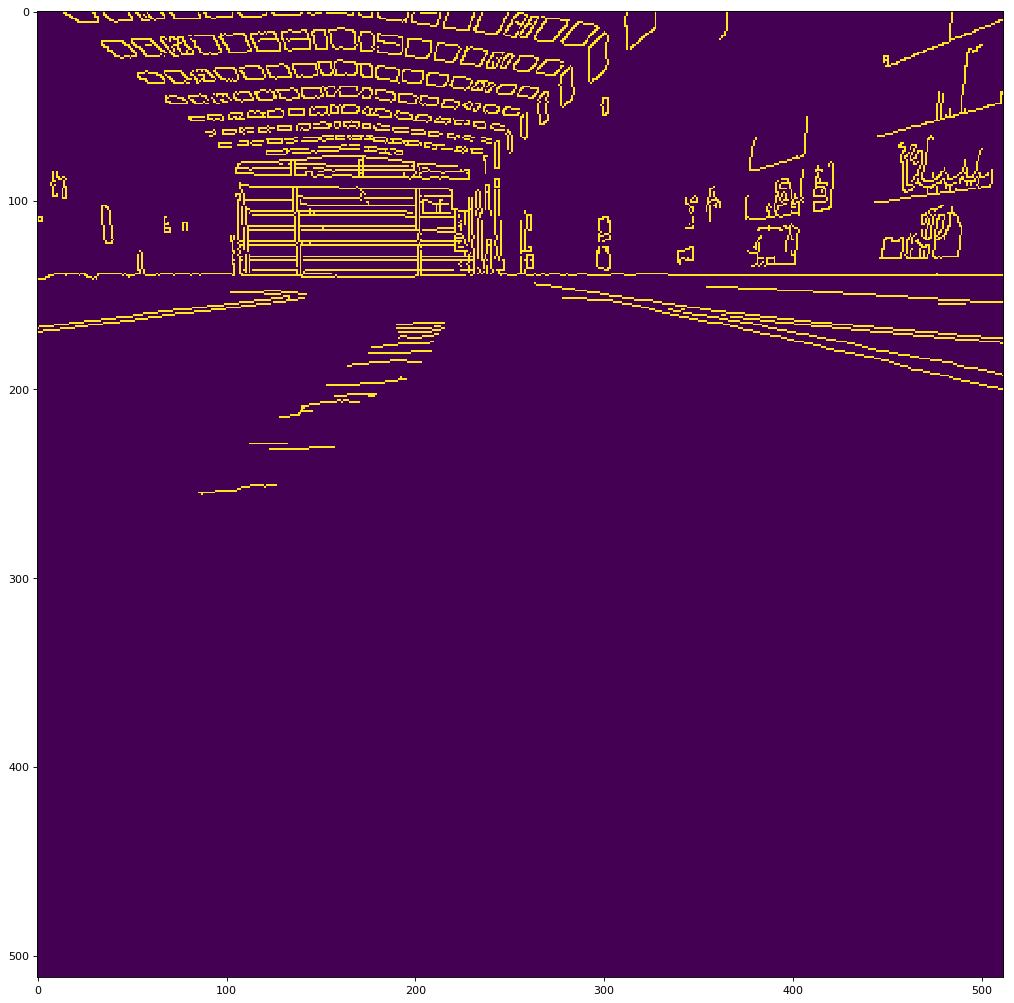

In [4]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
edges = cv2.Canny(Image,100,300)
plt.imshow(edges)

Now that we have the edges we can see the horizon(which is a horizontal line) we do a Hough transform to find it.

Horizon is at:  140.0


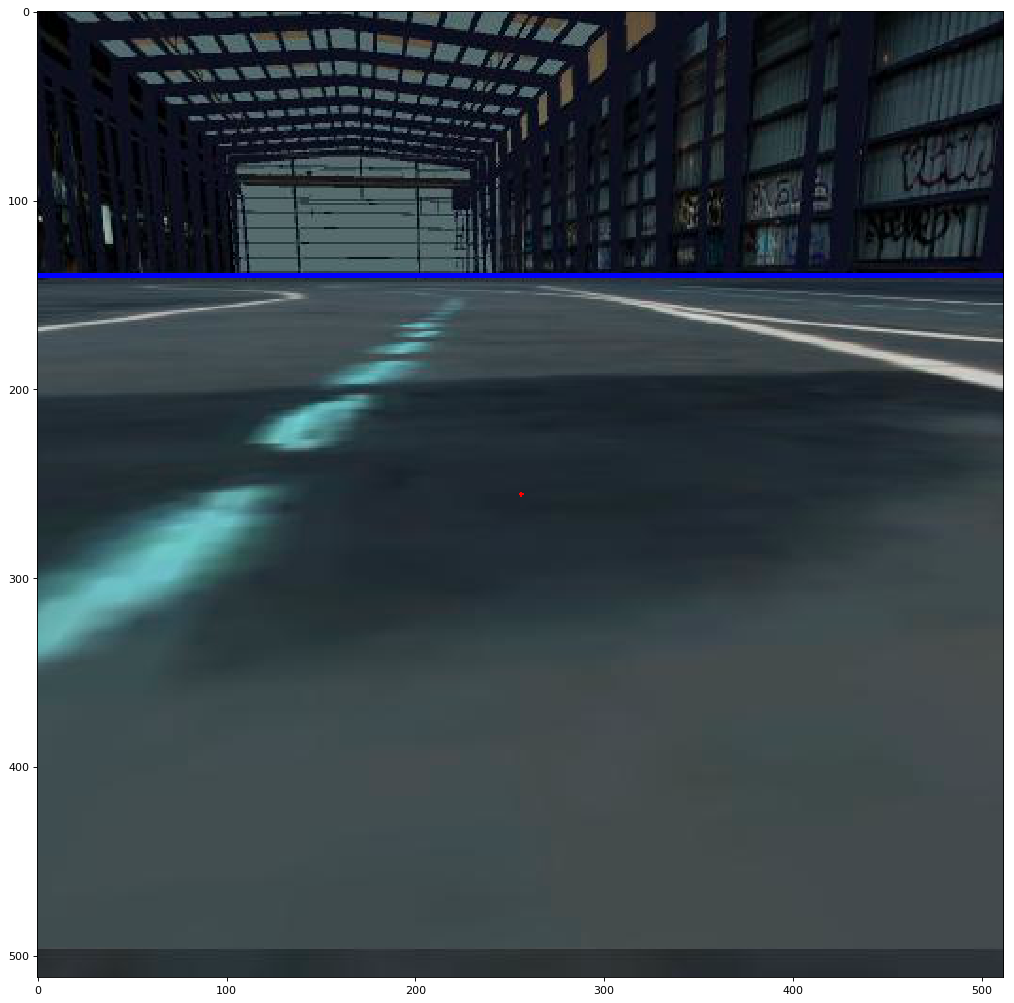

In [55]:

lines = cv2.HoughLines(edges,1,np.pi/180,200)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(Image,(x1,y1),(x2,y2),(0,0,255),2)
print('Horizon is at: ', y0)
horizon=y0
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(Image)


## Step 2

Finding the center

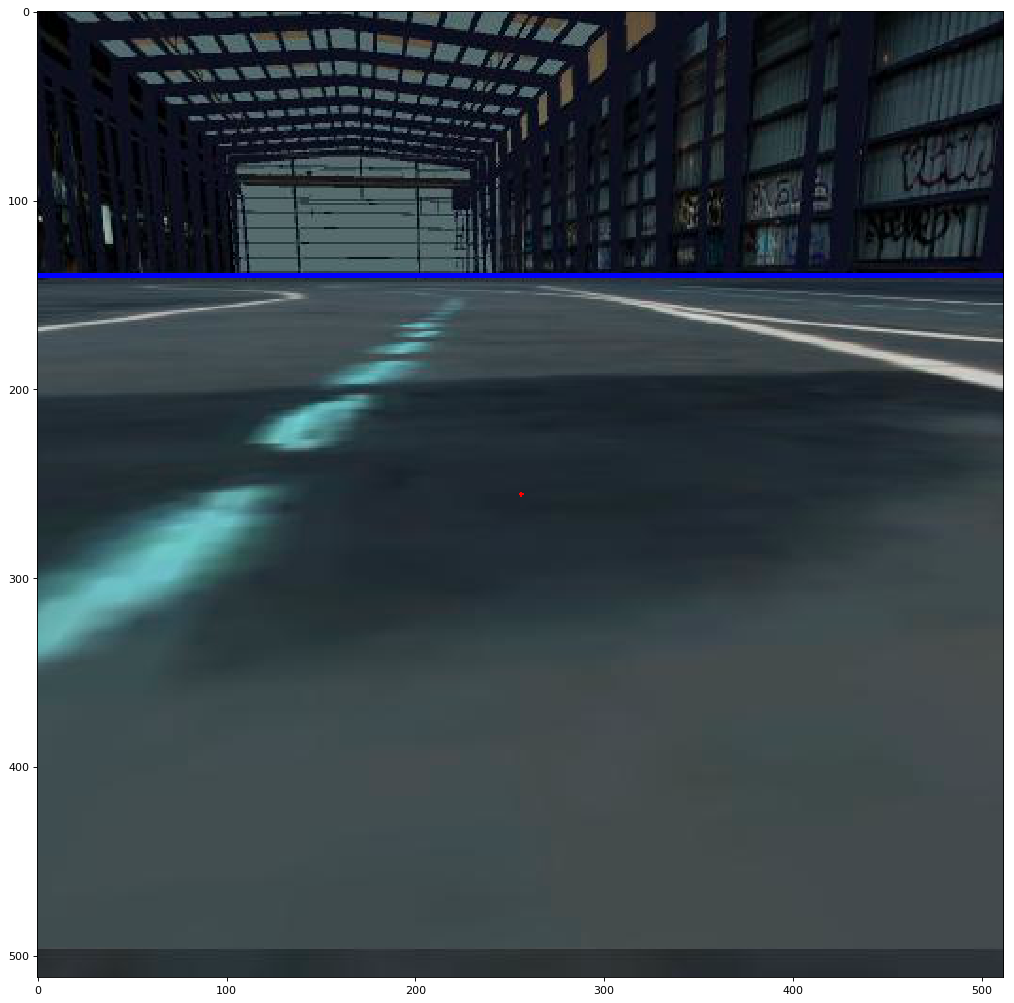

In [47]:
Imagex,Imagey,_ = Image.shape
center = (int(Imagex/2),int(Imagey/2))
cv2.circle(Image,center, 1, (255,0,0), -1)
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(Image)

For this particular instance the angle of the camera is 15 degrees and height is 2( in world units... what is the equivalent actual units) . This has to be changed if we change it later.

In [7]:
angle = np.radians(15)
height = 2

So horizontal distance to the red dot is simply.
$$ L_{mid} = \frac{h}{\tan{15^\circ}}$$

In [8]:
L_mid = height/np.tan(angle)
print('The horizontal distance to the red dot is: ', L_mid)

The horizontal distance to the red dot is:  7.46410161514


Our field of view for this instance is 60 degrees which means the bottom of our image is at the camera angel+ 1/2 field of view

In [9]:
FOV = 60
bottom_Angle = angle + np.radians(FOV/2)
L_bot = height/np.tan(bottom_Angle)
print('The horizontal distance to the bottom of the screen is: ', L_bot)

The horizontal distance to the bottom of the screen is:  2.0


We want to take advantage of the full length of the screen in the middle part. So we need to extend the screen at the bottom but by how much?

Doing a little math you can find that the proportion between the length of the top and the bottom is $$\alpha = \frac{L_{mid}}{L_{bot}}$$

In [14]:
alpha = L_mid/L_bot
print("proportion: ", alpha)

proportion:  3.73205080757


So we need to add borders equal to $\frac{n(\alpha -1)}{2}$ on either side. where n is the original number of pixels in the x direction 

In [40]:
border_size = int(np.ceil(Imagex*(alpha-1)/2))
print('Border size needs to be', border_size, 'pixels.')

Border size needs to be 700 pixels.


But first to make it nice let's add the midwayline.

In [123]:
print((0,bordery),(int(border_size*(-bordery+horizon)/(center[1]-bordery)),horizon))
print((int((bordery-center[1])*center[0]/(horizon-center[1])),bordery))

(0, 512) (1017, 140.0)
(-564, 512)


In [144]:
border=cv2.copyMakeBorder(Image,top=0,bottom=0, left=border_size, right=border_size, borderType= cv2.BORDER_CONSTANT)
cv2.line(border,(border_size,center[1]),(border_size+Imagex,center[1]),(255,0,0),3)
bordery,borderx,_ = border.shape
x_1,y_1 =(border_size,center[1])
x_2,y_2 = (border_size+center[0],horizon)
x_3,y_3 = (border_size+Imagex,center[1])
y_0 = bordery
def x_0(y_0):
    return(int((y_0-y_1)*(x_2-x_1)/(y_2-y_1))+x_1)
y_4 = bordery
def x_4(y_4):
    return(int((y_4-y_1)*(x_2-x_3)/(y_2-y_3))+x_3)
cv2.line(border,(x_0(y_0),y_0),(x_2,y_2),(255,0,0),3);
cv2.line(border,(x_4(y_4),y_4),(x_2,y_2),(255,0,0),3);
cv2.circle(border,(x_0(int((center[1]-horizon)/2)),int((center[1]-horizon)/2)),5,(0,255,0))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [145]:
help(cv2.circle)

Help on built-in function circle:

circle(...)
    circle(img, center, radius, color[, thickness[, lineType[, shift]]]) -> img
    .   @brief Draws a circle.
    .   
    .   The function circle draws a simple or filled circle with a given center and radius.
    .   @param img Image where the circle is drawn.
    .   @param center Center of the circle.
    .   @param radius Radius of the circle.
    .   @param color Circle color.
    .   @param thickness Thickness of the circle outline, if positive. Negative thickness means that a
    .   filled circle is to be drawn.
    .   @param lineType Type of the circle boundary. See the line description.
    .   @param shift Number of fractional bits in the coordinates of the center and in the radius value.



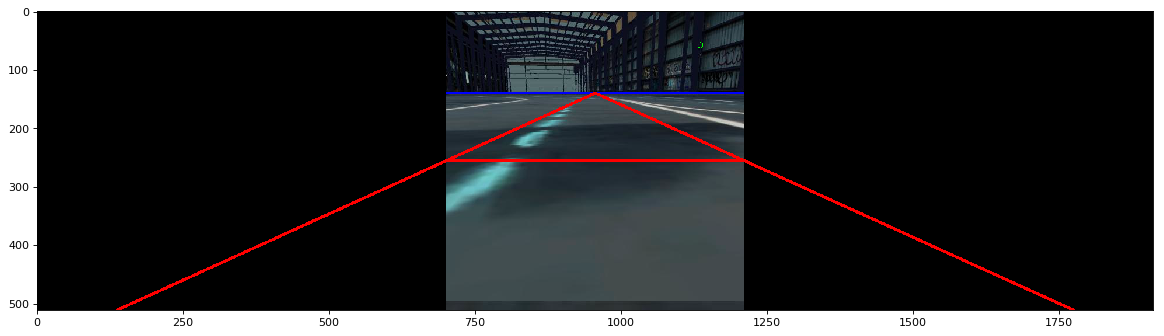

In [146]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(border)
plt.show()

So now we will draw the lines that indicate the straight line on the bird's eye view.

So now we need to pick a point along both lines make a line figure out that distance and do a perspective transform.

Also the distance up is linear with angle. 